# Comparing All Optimization Results

In [54]:
import math
import random
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression
import networkx as nx
import warnings
import geopandas as gpd
from shapely.geometry import Point, LineString
from matplotlib.colors import ListedColormap
from shapely.geometry import MultiPoint
import matplotlib.image as mpimg

%run data_cleaning.ipynb
%run optimization_functions.ipynb

### Import all necessary data

In [55]:
centroid_locations = pd.read_csv(r"C:\Users\dodie\Downloads\spring 2024\trio-capstone\data\CensusTractCentroids.csv")
metro_locations = pd.read_csv(r"C:\Users\dodie\Downloads\spring 2024\trio-capstone\data\MetroLinkStations_REGISTERED.csv")
north_south_locations = pd.read_csv(r"C:\Users\dodie\Downloads\spring 2024\trio-capstone\data\MetroLinkStations_NS.csv")
census_data = data = pd.read_csv(r"C:\Users\dodie\Downloads\spring 2024\trio-capstone\data\B08119_stl_city.csv")
race_data = pd.read_csv(r"C:\Users\dodie\Downloads\spring 2024\trio-capstone\data\B08105_stl_city.csv")
stl = nx.read_weighted_edgelist(r"C:\Users\dodie\Downloads\spring 2024\trio-capstone\data pulling code\weighted_dual_list",delimiter='%')

In [56]:
'''
centroid_locations = pd.read_csv(r"data\CensusTractCentroids.csv")
metro_locations = pd.read_csv(r"data\MetroLinkStations_REGISTERED.csv")
north_south_locations = pd.read_csv(r"data\MetroLinkStations_NS.csv")
census_data = data = pd.read_csv(r"data\B08119_stl_city.csv")
race_data = pd.read_csv(r"data\B08105_stl_city.csv")
stl = nx.read_weighted_edgelist(r"data\weighted_dual_list",delimiter='%',nodetype=str)
'''

'\ncentroid_locations = pd.read_csv(r"data\\CensusTractCentroids.csv")\nmetro_locations = pd.read_csv(r"data\\MetroLinkStations_REGISTERED.csv")\nnorth_south_locations = pd.read_csv(r"data\\MetroLinkStations_NS.csv")\ncensus_data = data = pd.read_csv(r"data\\B08119_stl_city.csv")\nrace_data = pd.read_csv(r"data\\B08105_stl_city.csv")\nstl = nx.read_weighted_edgelist(r"data\\weighted_dual_list",delimiter=\'%\',nodetype=str)\n'

### Clean the data and set constants

In [57]:
k = 14 #number of clusters/metro stops for all algorithms

total_weight = 0
for edge in stl.edges(data=True):
    total_weight = total_weight + edge[2]['weight'] 
for edge in stl.edges(data=True):
    stl[edge[0]][edge[1]]['weight'] = total_weight - edge[2]['weight']


by_tract = clean(census_data, race_data)
centroid_locations_small = centroid_locations[['NAMELSAD','INTPTLAT','INTPTLON']]
centroid_locations_small = centroid_locations_small.rename(columns = {"NAMELSAD": "location", "INTPTLAT" : "LAT", "INTPTLON" : "LON"})
full_data = by_tract.merge(centroid_locations_small, on='location')
full_data.head()

,location,estimate,transit weight,income weight,race weight,node id,LAT,LON
0,Census Tract 1011,1039,0.003275,0.009653,0.007499,1011,38.554718,-90.273620
1,Census Tract 1012,1921,0.001162,0.009570,0.012480,1012,38.561824,-90.274863
2,Census Tract 1013,2161,0.003697,0.009560,0.013909,1013,38.566560,-90.264211
3,Census Tract 1014,1502,0.010036,0.009614,0.010099,1014,38.562243,-90.253522
4,Census Tract 1015,1318,0.003381,0.009645,0.008554,1015,38.548544,-90.264511


### Original Stops

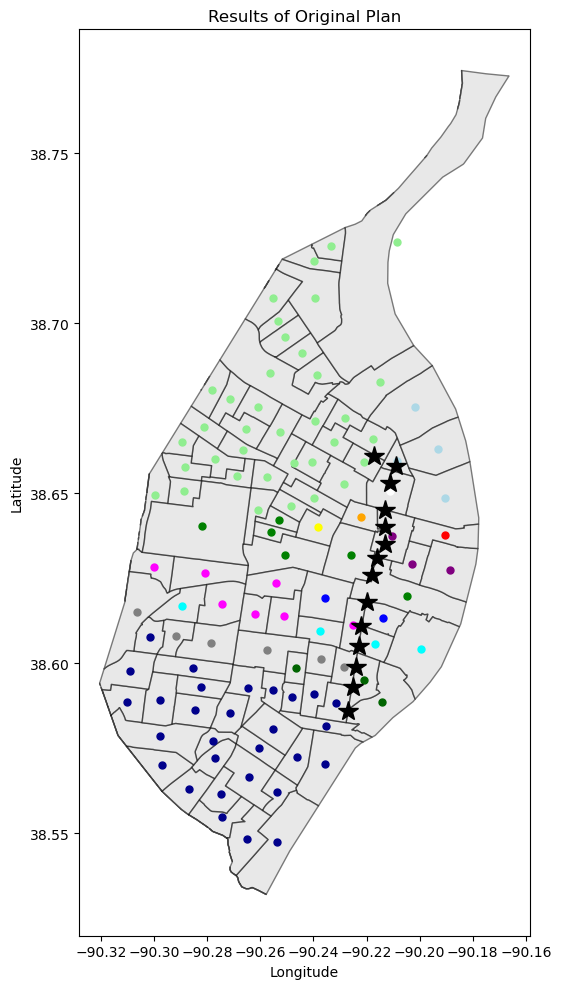

In [5]:
orig_stops = [[lat, lon] for lat, lon in zip(north_south_locations['LON'],north_south_locations['LAT'])]
orig_labels = graph_from_lp(full_data, orig_stops)
cluster_dict = {k:v for k, v in zip(full_data['node id'],orig_labels)}
orig_graph = stl.copy()
nx.set_node_attributes(orig_graph, cluster_dict, 'cluster')
nx.write_gexf(orig_graph, "capstone.gexf")
graph_results_lp(orig_graph, orig_stops, 'Original Plan')

### K-Means

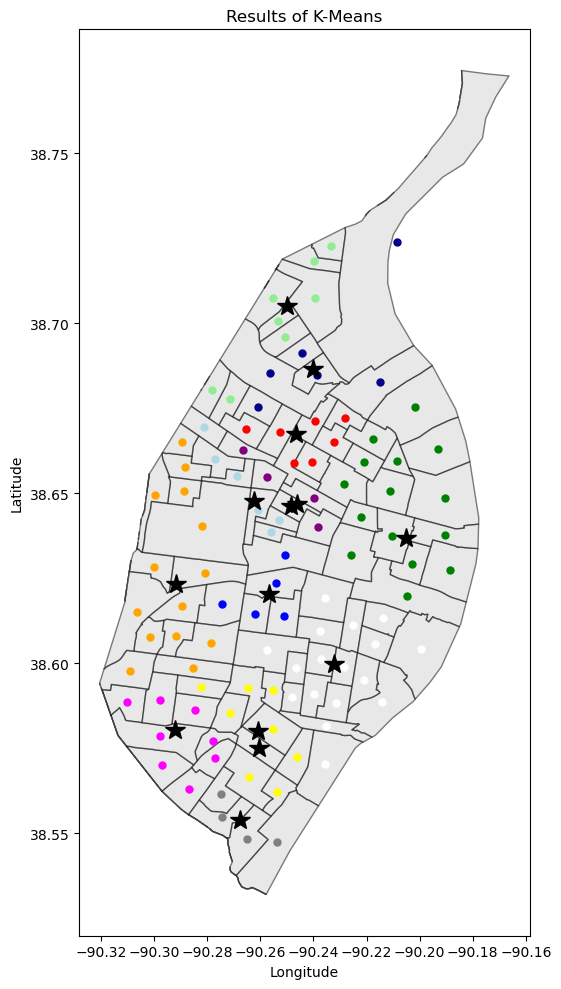

In [6]:
k_means_weight = 'estimate'
k_means_stops, labels = weighted_kmeans(full_data, k, k_means_weight)
cluster_dict = {k:v for k, v in zip(full_data['node id'],labels)}
k_means_graph = stl.copy()
nx.set_node_attributes(k_means_graph, cluster_dict, 'cluster')
nx.write_gexf(k_means_graph, "capstone.gexf")
graph_results_lp(k_means_graph, k_means_stops, 'K-Means')

### Linear Programming

In [7]:
lp_stops = linear_programming(full_data)

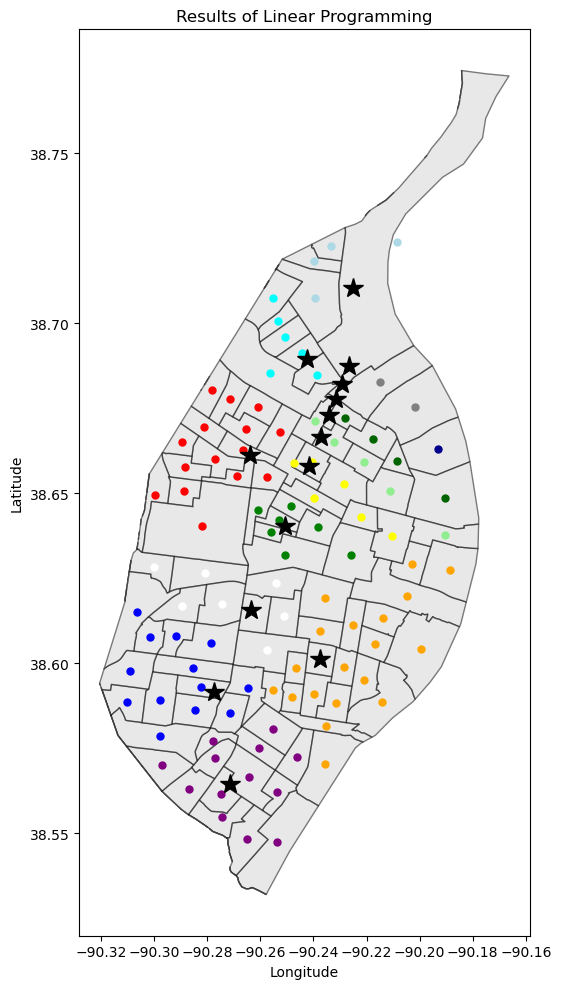

In [8]:
labels = graph_from_lp(full_data, lp_stops)
cluster_dict = {k:v for k, v in zip(full_data['node id'],labels)}
lp_graph = stl.copy()
nx.set_node_attributes(lp_graph, cluster_dict, 'cluster')
nx.write_gexf(lp_graph, "capstone.gexf")
graph_results_lp(lp_graph, lp_stops, 'Linear Programming')

### Modularity Maximization

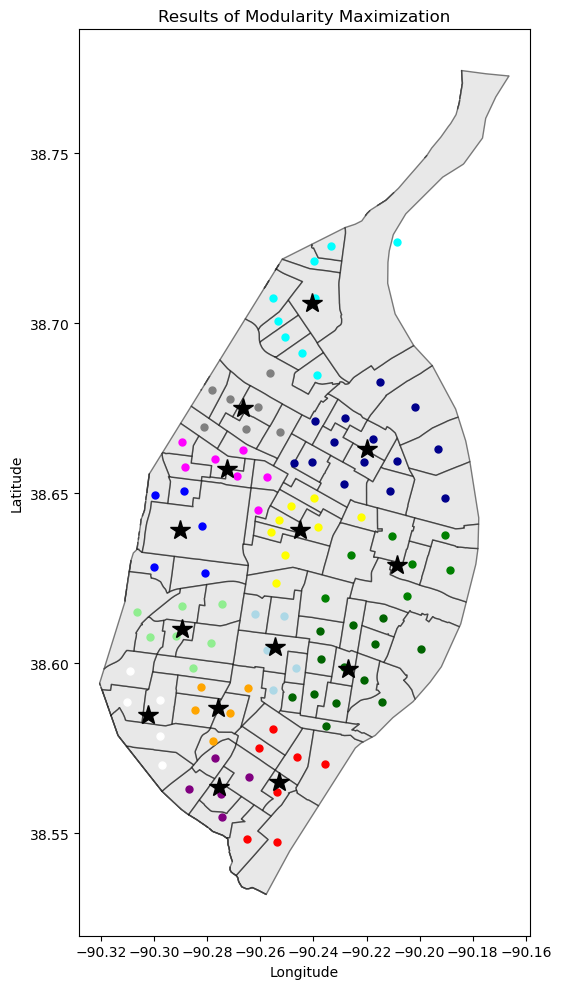

In [58]:
mod_max = mod_max_weighted(stl,k)
nx.write_gexf(mod_max, "capstone.gexf")
mm_stops = graph_results(mod_max, 'Modularity Maximization')

# Evaluating Methods Against One Another

In [25]:
total_orig_dist = dist_to_nearest_stop_eval(full_data, orig_stops)
orig_unweighted_eval = np.mean(total_orig_dist)
orig_race_eval = np.dot(full_data['race weight'], total_orig_dist)
orig_income_eval = np.dot(full_data['income weight'], total_orig_dist)
orig_transit_eval = np.dot(full_data['transit weight'], total_orig_dist)
print(f'Original plan unweighted eval: {orig_unweighted_eval}')
print(f'Original plan race eval: {orig_race_eval}')
print(f'Original plan income eval: {orig_income_eval}')
print(f'Original plan transit eval: {orig_transit_eval}\n')


total_lp_dist = dist_to_nearest_stop_eval(full_data, lp_stops)
lp_unweighted_eval = np.mean(total_lp_dist)
lp_race_eval = np.dot(full_data['race weight'], total_lp_dist)
lp_income_eval = np.dot(full_data['income weight'], total_lp_dist)
lp_transit_eval = np.dot(full_data['transit weight'], total_lp_dist)
print(f'LP unweighted eval: {lp_unweighted_eval}')
print(f'LP race eval: {lp_race_eval}')
print(f'LP income eval: {lp_income_eval}')
print(f'LP transit eval: {lp_transit_eval}\n')


total_km_dist = dist_to_nearest_stop_eval(full_data, k_means_stops)
km_unweighted_eval = np.mean(total_km_dist)
km_race_eval = np.dot(full_data['race weight'], total_km_dist)
km_income_eval = np.dot(full_data['income weight'], total_km_dist)
km_transit_eval = np.dot(full_data['transit weight'], total_km_dist)
print(f'K-Means unweighted eval: {km_unweighted_eval}')
print(f'K-Means race eval: {km_race_eval}')
print(f'K-Means income eval: {km_income_eval}')
print(f'K-Means transit eval: {km_transit_eval}\n')

total_mm_dist = dist_to_nearest_stop_eval(full_data, mm_stops)
mm_unweighted_eval = np.mean(total_mm_dist)
mm_race_eval = np.dot(full_data['race weight'], total_mm_dist)
mm_income_eval = np.dot(full_data['income weight'], total_mm_dist)
mm_transit_eval = np.dot(full_data['transit weight'], total_mm_dist)
print(f'Mod Max unweighted eval: {mm_unweighted_eval}')
print(f'Mod Max race eval: {mm_race_eval}')
print(f'Mod Max income eval: {mm_income_eval}')
print(f'Mod Max transit eval: {mm_transit_eval}\n')

Original plan unweighted eval: 2.576640526686878
Original plan race eval: 2.6497651058001117
Original plan income eval: 2.5754517384268776
Original plan transit eval: 2.1424966090703292

LP unweighted eval: 1.173943584651913
LP race eval: 1.2164717312373936
LP income eval: 1.1734518382221073
LP transit eval: 1.205248194959301

K-Means unweighted eval: 0.9362099573591305
K-Means race eval: 0.8867709912941087
K-Means income eval: 0.9367758599023479
K-Means transit eval: 0.9690862995573094

Mod Max unweighted eval: 0.7714954073980583
Mod Max race eval: 0.7566890511056602
Mod Max income eval: 0.7716733412347119
Mod Max transit eval: 0.7704906686887177



## Graphs for Evaluation

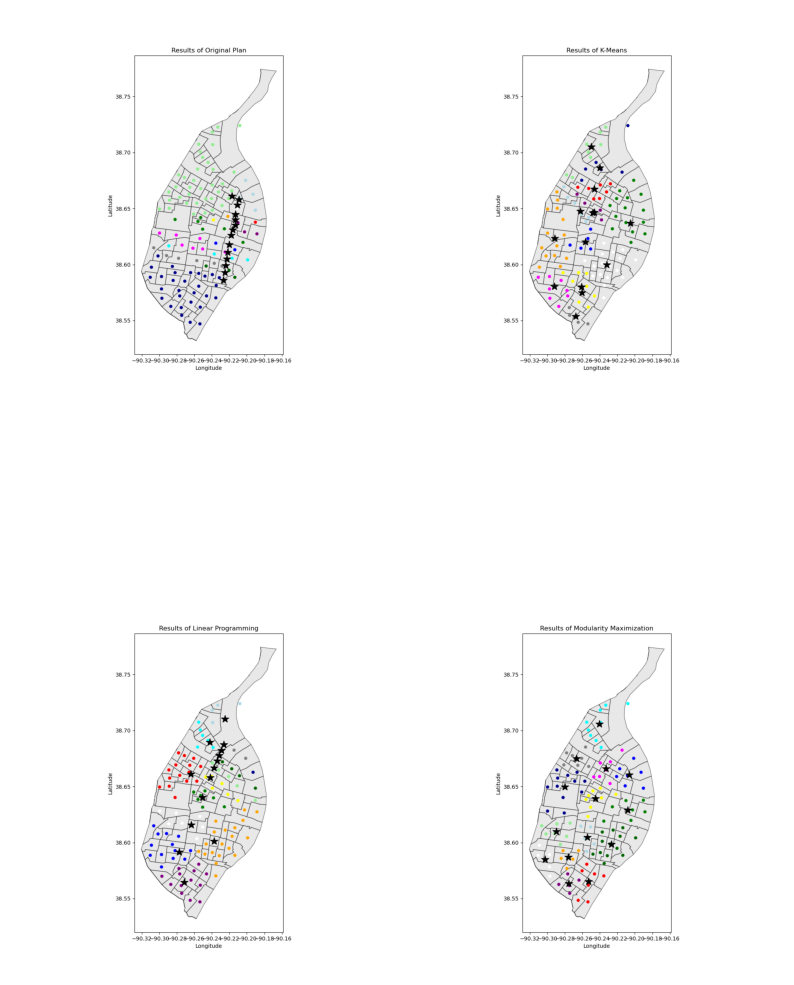

In [11]:
orig = mpimg.imread('Original Plan.png')
lp = mpimg.imread('K-Means.png')
km = mpimg.imread('Linear Programming.png')
mm = mpimg.imread('Modularity Maximization.png')

plt.figure(figsize=(10,15)) 
plt.subplots_adjust(wspace=0,hspace=0)
plt.subplot(2,2,1) 
plt.imshow(orig)
plt.axis('off')
plt.subplot(2,2,2)
plt.imshow(lp)
plt.axis('off')
plt.subplot(2,2,3) 
plt.imshow(km)
plt.axis('off')
plt.subplot(2,2,4)
plt.imshow(mm)
plt.axis('off')
plt.savefig('four compared.png')
plt.show()

## Save plans as point shapefiles


In [12]:
def arr2SHP(np_array, output_shapefile):
    df = gpd.GeoDataFrame(geometry=[Point(lonlat) for lonlat in np_array], crs="EPSG:4326")
    df.to_file(output_shapefile, driver="ESRI Shapefile")

In [13]:
arr2SHP(orig_stops, "plans\OrigStops.shp")
arr2SHP(k_means_stops, "plans\KMeansStops.shp")
arr2SHP(lp_stops, "plans\LPStops.shp")
arr2SHP(mm_stops, "plans\MMStops.shp")